#### Validation of NEST and SpiNNaker running a Microcircuit simulation

This notebook presents some validation tests to compare the overall activity to a defined reference. Depending on the features of interest and the system at hand different methods are applied in order to quantify the quantify the differences and their significance.

Here system to validate is a simluation of a cortical microcircuit run on the neuromorphic hardware SpiNNaker. The reference is the same simulation but run with NEST on a conventional supercomputer.
The feature by which these two system shall be compared is the correlation structure.

This analyis is a continuation of the work presented in the *NEST SpiNNaker Elephant Demo* collab (https://collab.humanbrainproject.eu/#/collab/507/nav/5200).

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from quantities import ms
import sys
import imp
import os
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

<style>

html {
  font-size: 62.5% !important; }
body {
  font-size: 1.5em !important; /* currently ems cause chrome bug misinterpreting rems on body element */
  line-height: 1.6 !important;
  font-weight: 400 !important;
  font-family: "Raleway", "HelveticaNeue", "Helvetica Neue", Helvetica, Arial, sans-serif !important;
  color: #222 !important; }

div{ border-radius: 0px !important;  }
div.CodeMirror-sizer{ background: rgb(244, 244, 248) !important; }
div.input_area{ background: rgb(244, 244, 248) !important; }

div.out_prompt_overlay:hover{ background: rgb(244, 244, 248) !important; }
div.input_prompt:hover{ background: rgb(244, 244, 248) !important; }

h1, h2, h3, h4, h5, h6 {
  color: #333 !important;
  margin-top: 0 !important;
  margin-bottom: 2rem !important;
  font-weight: 300 !important; }
h1 { font-size: 4.0rem !important; line-height: 1.2 !important;  letter-spacing: -.1rem !important;}
h2 { font-size: 3.6rem !important; line-height: 1.25 !important; letter-spacing: -.1rem !important; }
h3 { font-size: 3.0rem !important; line-height: 1.3 !important;  letter-spacing: -.1rem !important; }
h4 { font-size: 2.4rem !important; line-height: 1.35 !important; letter-spacing: -.08rem !important; }
h5 { font-size: 1.8rem !important; line-height: 1.5 !important;  letter-spacing: -.05rem !important; }
h6 { font-size: 1.5rem !important; line-height: 1.6 !important;  letter-spacing: 0 !important; }

@media (min-width: 550px) {
  h1 { font-size: 5.0rem !important; }
  h2 { font-size: 4.2rem !important; }
  h3 { font-size: 3.6rem !important; }
  h4 { font-size: 3.0rem !important; }
  h5 { font-size: 2.4rem !important; }
  h6 { font-size: 1.5rem !important; }
}

p {
  margin-top: 0 !important; }
  
a {
  color: #1EAEDB !important; }
a:hover {
  color: #0FA0CE !important; }
  
code {
  padding: .2rem .5rem !important;
  margin: 0 .2rem !important;
  font-size: 90% !important;
  white-space: nowrap !important;
  background: #F1F1F1 !important;
  border: 1px solid #E1E1E1 !important;
  border-radius: 4px !important; }
pre > code {
  display: block !important;
  padding: 1rem 1.5rem !important;
  white-space: pre !important; }
  
button{ border-radius: 0px !important; }
.navbar-inner{ background-image: none !important;  }
select, textarea{ border-radius: 0px !important; }

</style>

Disable scrolling in cell output

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

##### Load functions for validation and visualization

In [12]:
%%capture

def load_module(path, name):
    return imp.load_source('*', path + "/" + name)

path = os.getcwd()

dist = load_module(path + '/validation', 'dist.py')
matstat = load_module(path + '/validation', 'matrix.py')
load = load_module(path + '/validation', 'test_data.py')
vizi = load_module('/home/robin/Projects/INM6/Tasks/viziphant/plots', 'generic.py')

##### Load spiketrains from simulation

In [27]:
layer = ['spikes_L23', 'spikes_L4', 'spikes_L5', 'spikes_L6']

data_path = path + '/sim_data'

spiketrains_nest = load.load_data(data_path + '/NEST_data', layer, 100)

spiketrains_spinnaker = load.load_data(data_path + '/SpiNNaker_data', layer, 100)

##### Draw rasterplots for each layer

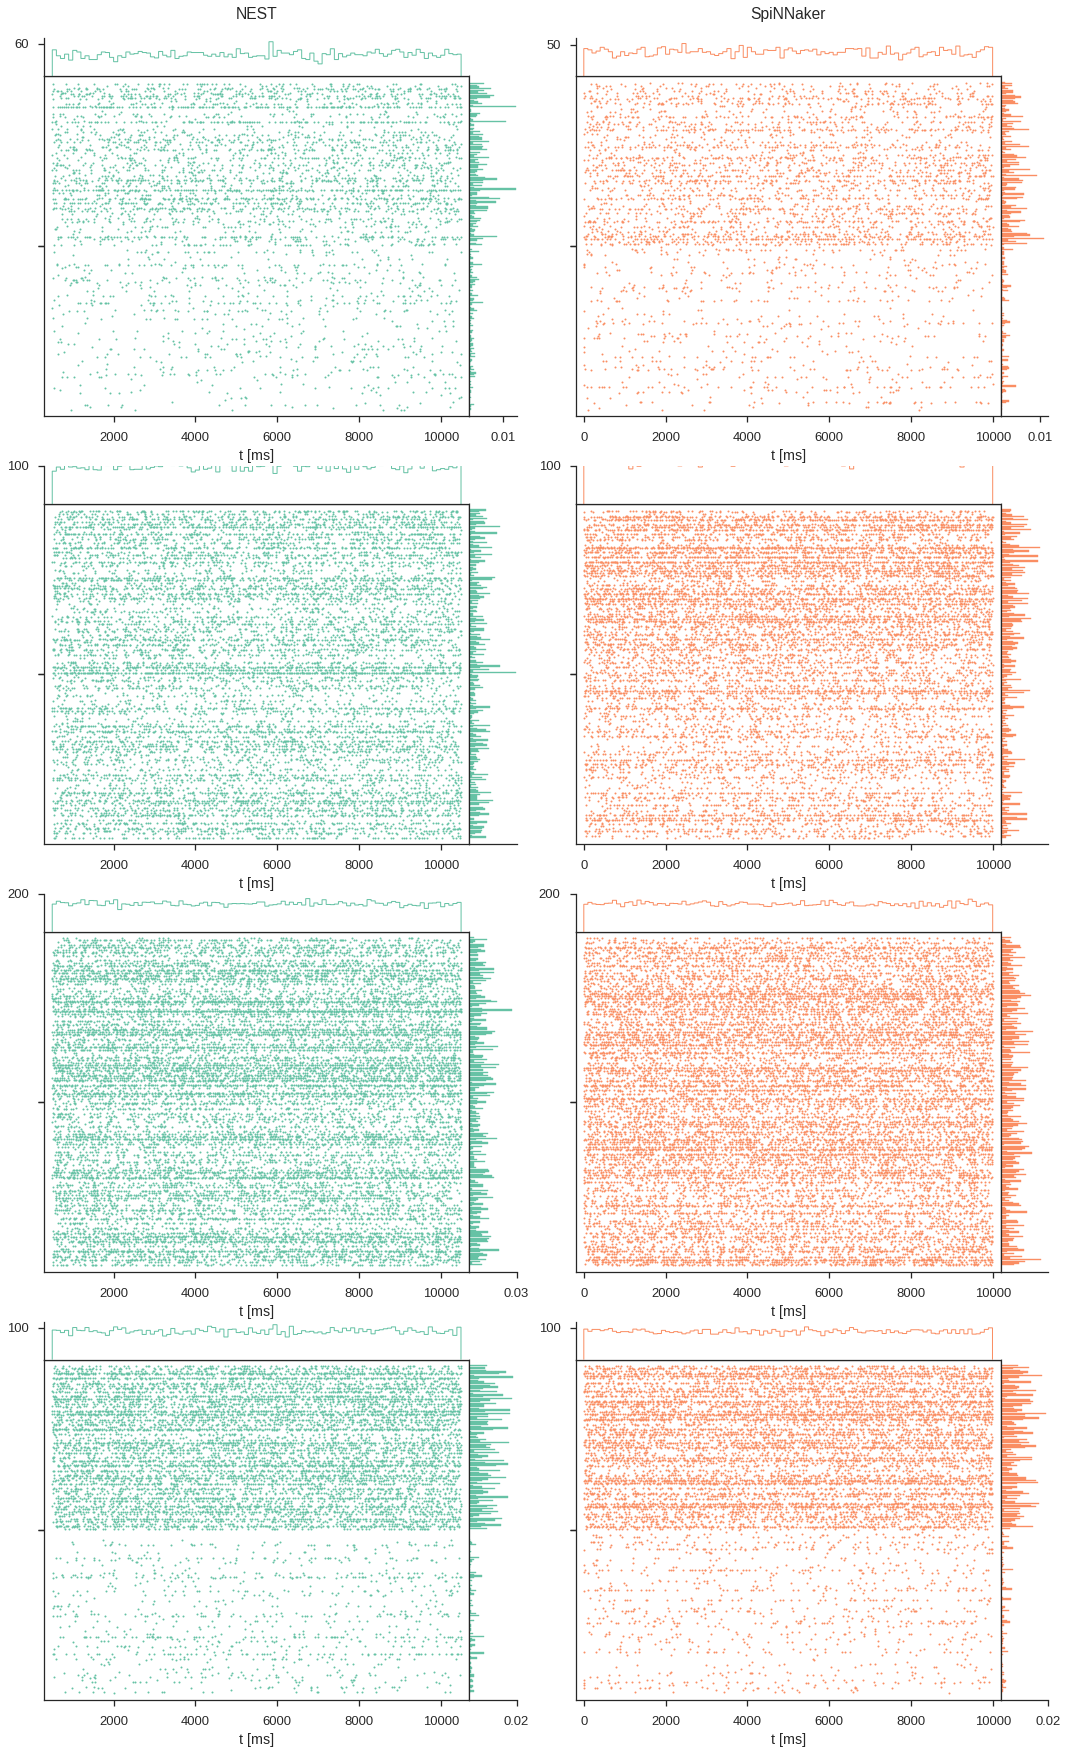

In [28]:
sns.set(style='ticks', context='talk')
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,6*len(layer)))
fig.tight_layout()

argdict={'key_list':['layer', 'type', ''], 'colorkey':'type', 'groupingdepth':2,
         'spacing':10, 'labelkey':'0+1', 'context':'talk'}

for i in range(len(layer)):
    __ = vizi.rasterplot(spiketrains_nest[i], ax=ax[i][0], palette=sns.color_palette('Set2')[::4], **argdict)
    __ = vizi.rasterplot(spiketrains_spinnaker[i], ax=ax[i][1], palette=sns.color_palette('Set2')[1::4], **argdict)

ax[0][0].text(.5, 1.17,'NEST', transform=ax[0][0].transAxes, ha='center')
ax[0][1].text(.5, 1.17,'SpiNNaker', transform=ax[0][1].transAxes, ha='center');

#### Compare the Distribution of Correlation-Coefficients

Calculate the correlation-coefficients and remove autocorrelatios

In [15]:
%%capture
def corrcoef(spiketrains):
    ccs = []
    for layer_count, layer_sts in enumerate(spiketrains):
        ccs += [[]]
        for type_count, typ_sts in enumerate(layer_sts):
            ccs[layer_count] += [matstat.corr_matrix(typ_sts,  binsize=2*ms).flatten()]   
            # remove autocorrelations
            ccs[layer_count][type_count][ccs[layer_count][type_count] == 1] = 0
    return ccs
    
corrcoefs_nest = corrcoef(spiketrains_nest)
corrcoefs_spinnaker = corrcoef(spiketrains_spinnaker)

Show coefficient distribution for all layers and neuron types

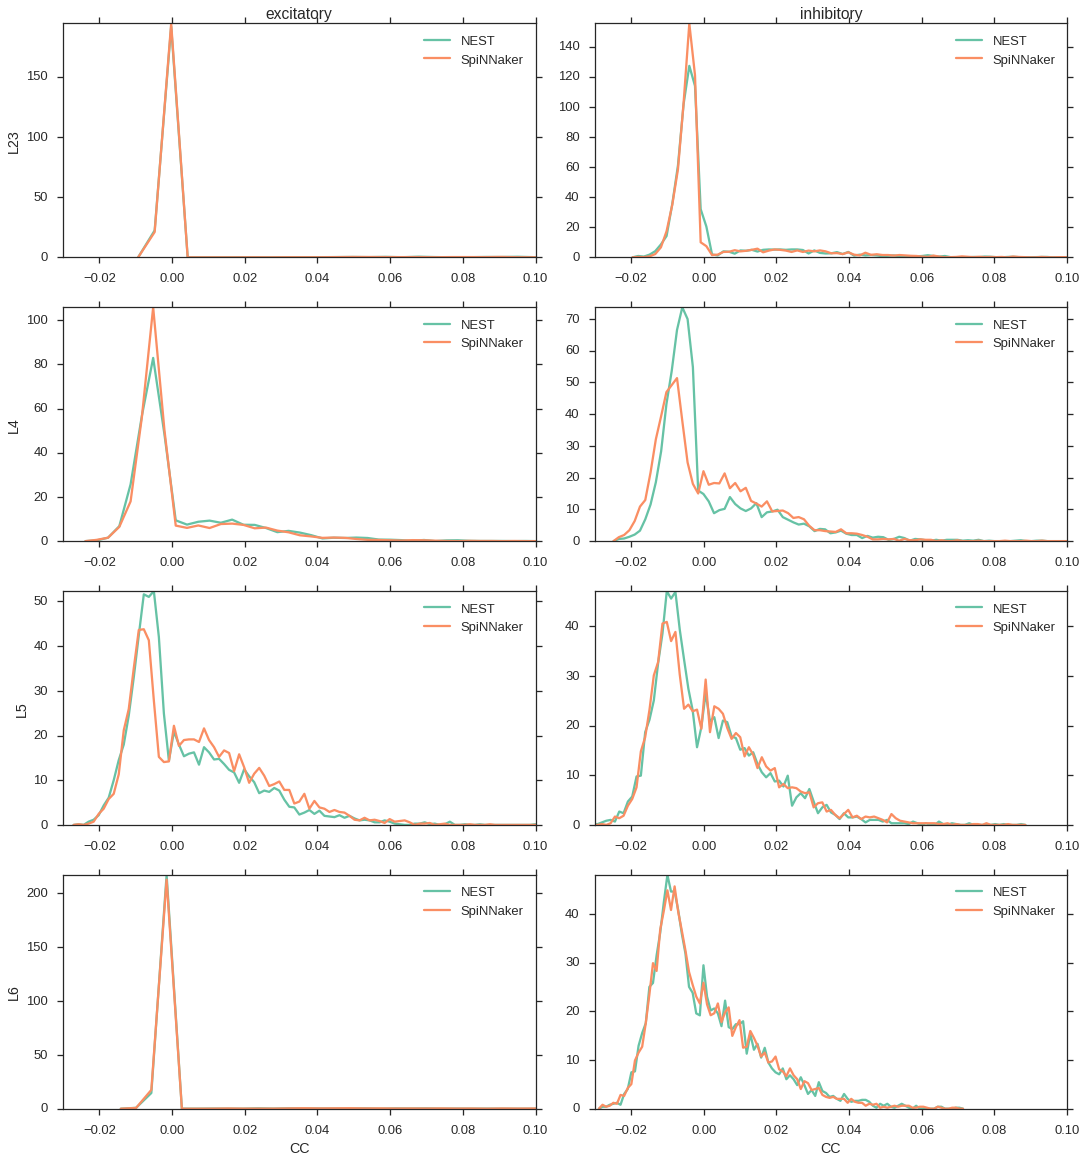

In [16]:
sns.set(style='ticks', palette='Set2', context='talk')
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        _ = dist.show(corrcoefs_nest[layer_count][typ_count], corrcoefs_spinnaker[layer_count][typ_count], 
                      bins=100, ax=ax[layer_count][typ_count])
        ax[layer_count][typ_count].legend(['NEST', 'SpiNNaker'])
        ax[layer_count][typ_count].set_xlim(-0.03,0.1)
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[0][0].legend(['NEST', 'SpiNNaker'])
ax[-1][0].set_xlabel('CC')
ax[-1][1].set_xlabel('CC');

##### Kullback-Leibler Divergence

$$ D_\mathrm{KL}(P||Q) =\sum_{i} P(i) \log_2 \frac{P(i)}{Q(i)} = H(P,Q) - H(P)$$
$ $

The [KL-Divergence](https://www.encyclopediaofmath.org/index.php/Kullback%e2%80%93Leibler_information) is a measure of difference between two distribution based on entropy. Graphically $D_\mathrm{KL}$ is size of the grey area indicated in the plots below.

When $P$ can be regarded as reference, $D_\mathrm{KL}$ is the amount of information lost when substituting $Q$ for $P$. Consequently this measure is asymetric.

$ $

Shown in grey in the graphs is $(P(i) - Q(i)) \cdot \log_2 \frac{P(i)}{Q(i)}$. Therefore the integral over the grey area is $D_\mathrm{KL}(P||Q) + D_\mathrm{KL}(Q||P)$.

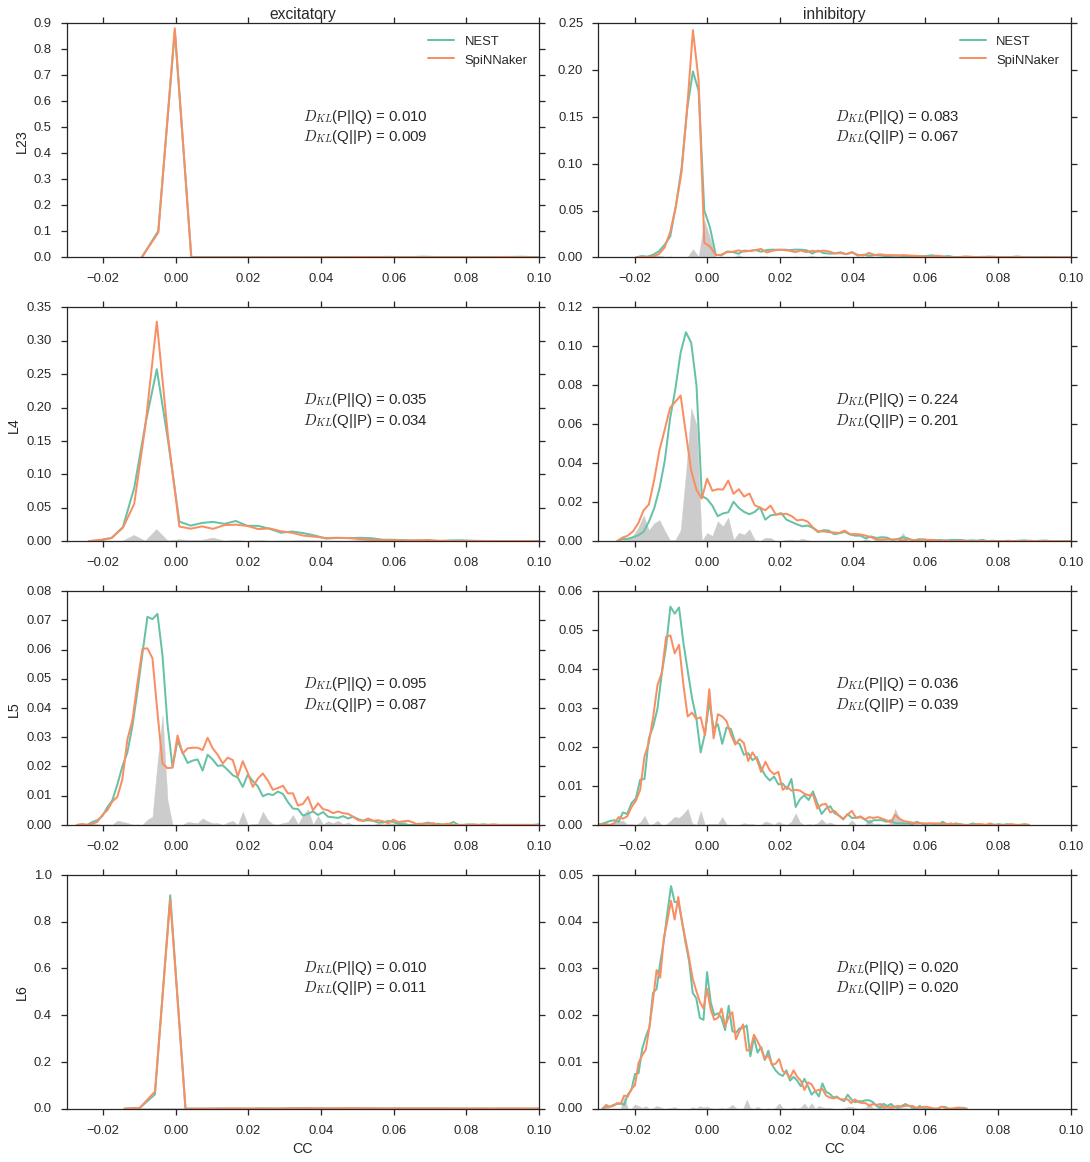

In [17]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        cc_nest = corrcoefs_nest[layer_count][typ_count]
        cc_spinnaker = corrcoefs_spinnaker[layer_count][typ_count]
        DKL, DKL_inv = dist.KL_test(cc_nest, cc_spinnaker, ax=ax[layer_count][typ_count], bins=100, 
                                    mute=True, xlabel='CC')
        ax[layer_count][typ_count].set_xlim(-0.03,0.1)
        ax[layer_count][typ_count].set_xlabel('');
        ax[layer_count][typ_count].set_ylabel('' if typ_count else layer_name.split('_')[1])
        ax[layer_count][typ_count].text(.5, .5, r'$D_{KL}$(P||Q) = ' + '{:.3f}\n'.format(DKL) 
                                        + r'$D_{KL}$(Q||P) = ' + '{:.3f}'.format(DKL_inv), 
                                        fontsize=15, transform=ax[layer_count][typ_count].transAxes)
ax[0][0].legend(['NEST', 'SpiNNaker'])
ax[0][1].legend(['NEST', 'SpiNNaker'])
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[-1][0].set_xlabel('CC')
ax[-1][1].set_xlabel('CC');

##### Kolmogorov-Smirnov Distance

$$ D_\mathrm{KS} = \sup | \hat{P}(x) - \hat{Q}(x) | $$
$ $

The [KS-Distance](https://www.encyclopediaofmath.org/index.php/Kolmogorov-Smirnov_test) measures the maximal vertical distance of the cumulative distributions $\hat{P}$ and $\hat{Q}$. This is a sensitive tool for detecting differences in mean, variance or distribution type. But it can't well detect deviations in the tails of the distributions. A possibily more powerful alternative would be the Cramér-von-Mises Test.

$ $

The null hypothesis that the underlying distributions are identical is rejected when the $D_\mathrm{KS}$ statistic is larger than a critical value $D_\alpha$ or equivalently when the correponding p-value is less than the signficance level $\alpha$.

$ $

Shown in the graphs below are the actual values of the samples as a dot display, the cumulative distribution functions,  and their vertical distance colored by the larger one of the respective two sample values.

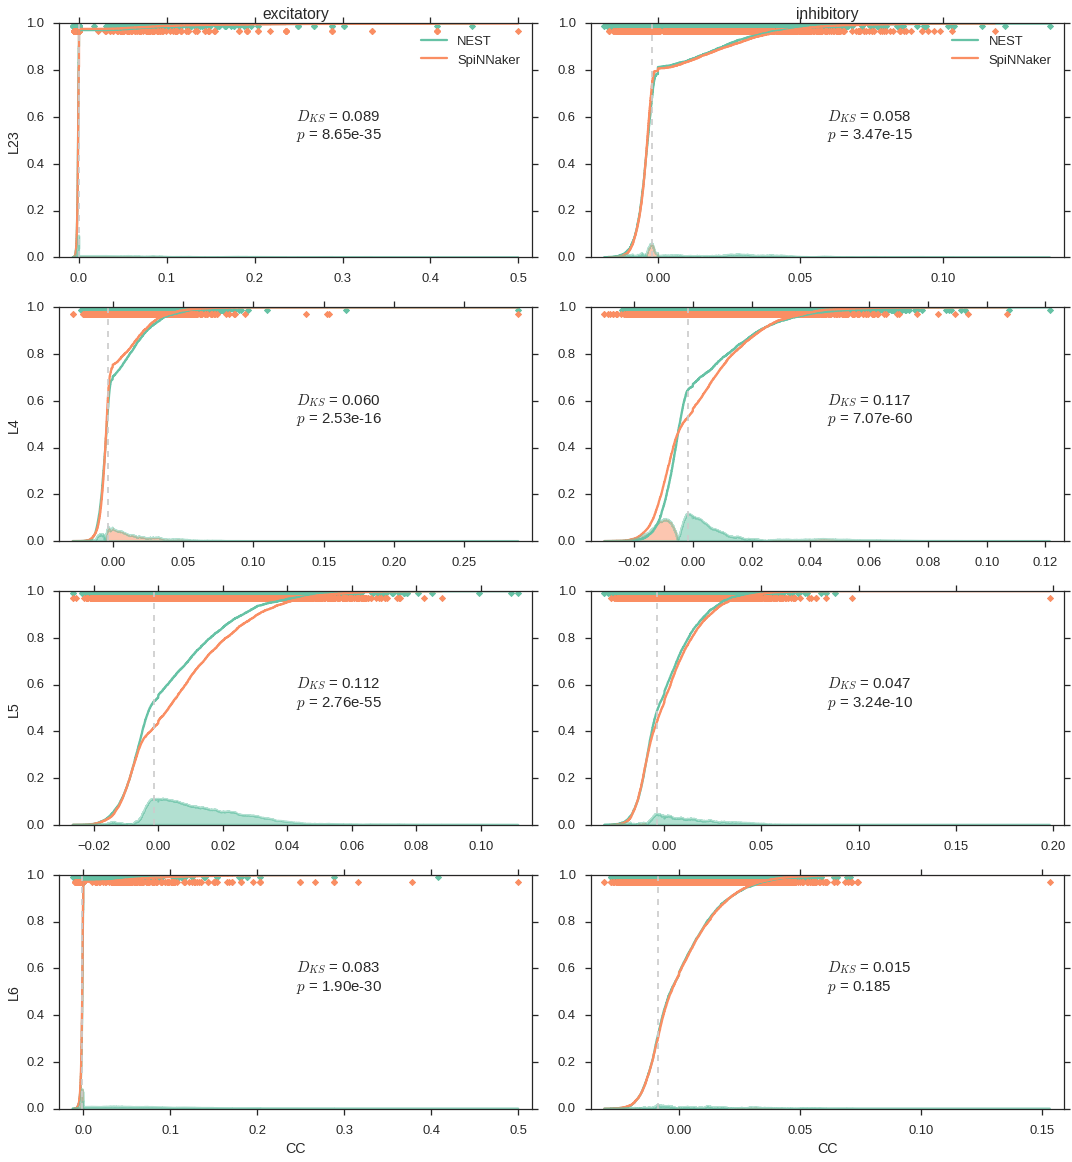

In [18]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        cc_nest = corrcoefs_nest[layer_count][typ_count]
        cc_spinnaker = corrcoefs_spinnaker[layer_count][typ_count]
        DKS, p = dist.KS_test(cc_nest, cc_spinnaker, ax=ax[layer_count][typ_count], mute=True)
        ax[layer_count][typ_count].set_xlabel('');
        ax[layer_count][typ_count].set_ylabel('' if typ_count else layer_name.split('_')[1])
        ax[layer_count][typ_count].text(.5, .5, r'$D_{KS}$ = ' + '{:.3f}\n'.format(DKS) 
                                        + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                                        fontsize=15, transform=ax[layer_count][typ_count].transAxes)
ax[0][0].legend(['NEST', 'SpiNNaker'])
ax[0][1].legend(['NEST', 'SpiNNaker'])
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[-1][0].set_xlabel('CC')
ax[-1][1].set_xlabel('CC');

#### Mann-Whitney U Test

$$ U_i = R_i - \frac{n_i(n_i + 1)}{2}\\ U = min(U_1,U_2) $$

$R_i$: rank sum

$n_i$: sample size

$ $

The [Mann-Whitney U](https://www.encyclopediaofmath.org/index.php/Mann-Whitney_test) is a rank statistic which test the null hypothesis that a random value of sample 1 is equally likely to be larger or a smaller value than a randomly chosen value of sample 2.

$ $

The $U_i$ statistic is in the range of $[0,n_1 n_2]$, and the $U=min(U_1,U_2)$ statistic is in the range of $[0,\frac{n_1 n_2}{2}]$.

$ $

For sample sizes $>20$ $U$ follows approximately a normal distribution. With this assumption a p-value can be inferred. The null hypothesis is consequently rejected when the p-value is less than the significance level.

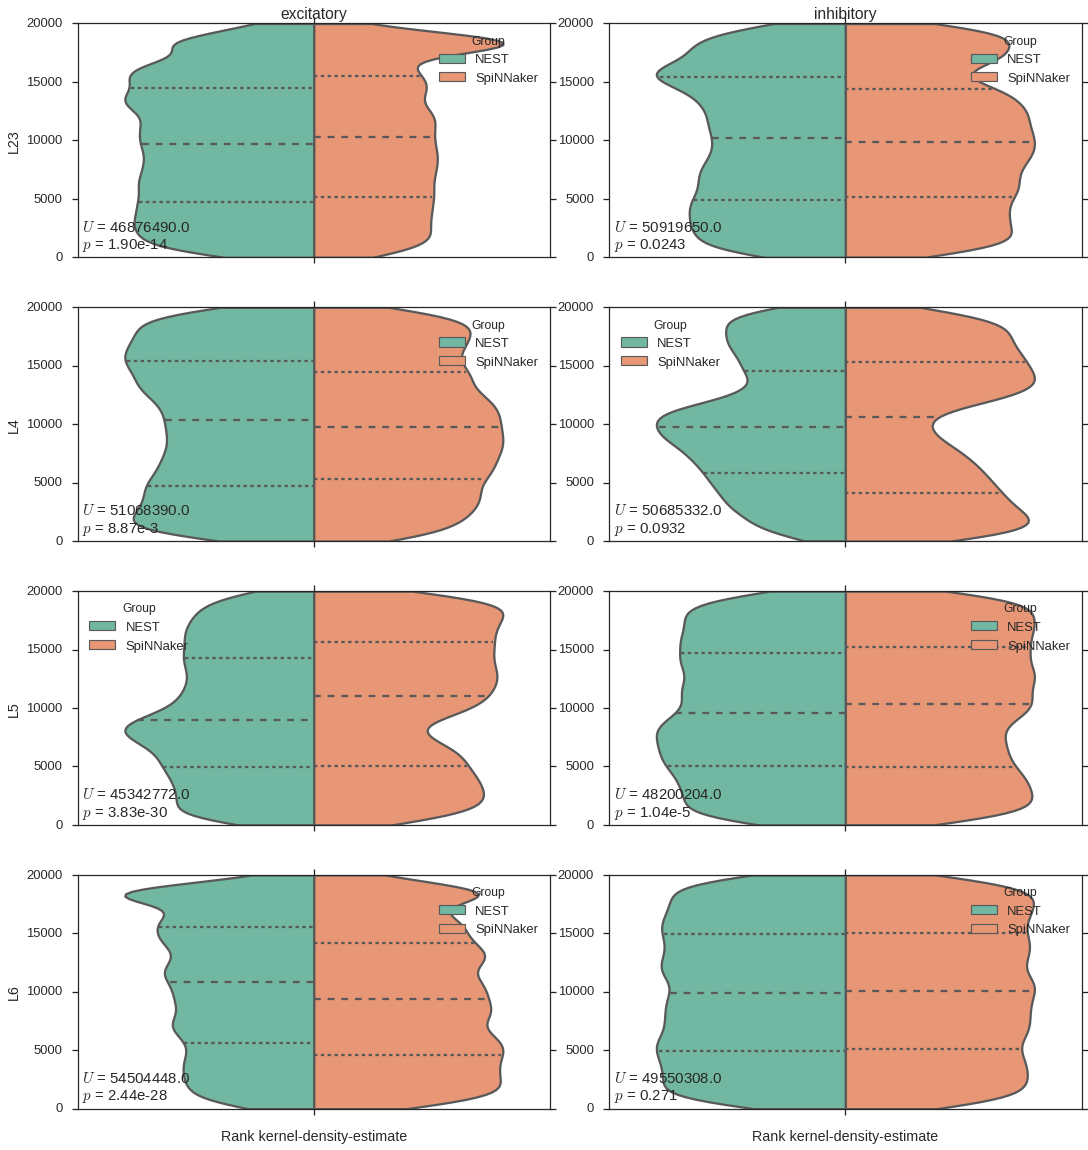

In [19]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    for typ_count in range(2):
        cc_nest = corrcoefs_nest[layer_count][typ_count][:]
        cc_spinnaker = corrcoefs_spinnaker[layer_count][typ_count][:]
        U, p = dist.MWU_test(cc_nest, cc_spinnaker, ax=ax[layer_count][typ_count], 
                             sample_names=['NEST', 'SpiNNaker'], excl_nan=True, mute=True)
        ax[layer_count][typ_count].set_xticklabels('')
        ax[layer_count][typ_count].set_xlabel('')
        ax[layer_count][typ_count].set_ylabel('' if typ_count else layer_name.split('_')[1])
        ax[layer_count][typ_count].text(.01, .03, r'$U$ = ' + '{}\n'.format(U) 
                                        + r'$p$ = ' + '{}'.format(dist.to_precision(p,3)), 
                                        fontsize=15, transform=ax[layer_count][typ_count].transAxes)
ax[0][0].set_title('excitatory')
ax[0][1].set_title('inhibitory')
ax[-1][0].set_xlabel('Rank kernel-density-estimate')
ax[-1][1].set_xlabel('Rank kernel-density-estimate');

### Compare the correlation matrices

For the analysis of the correlation structure the previous seperation between inhibitory and excitatory population is lifted and the calculations are performed layer-wise.

#### Heatmap

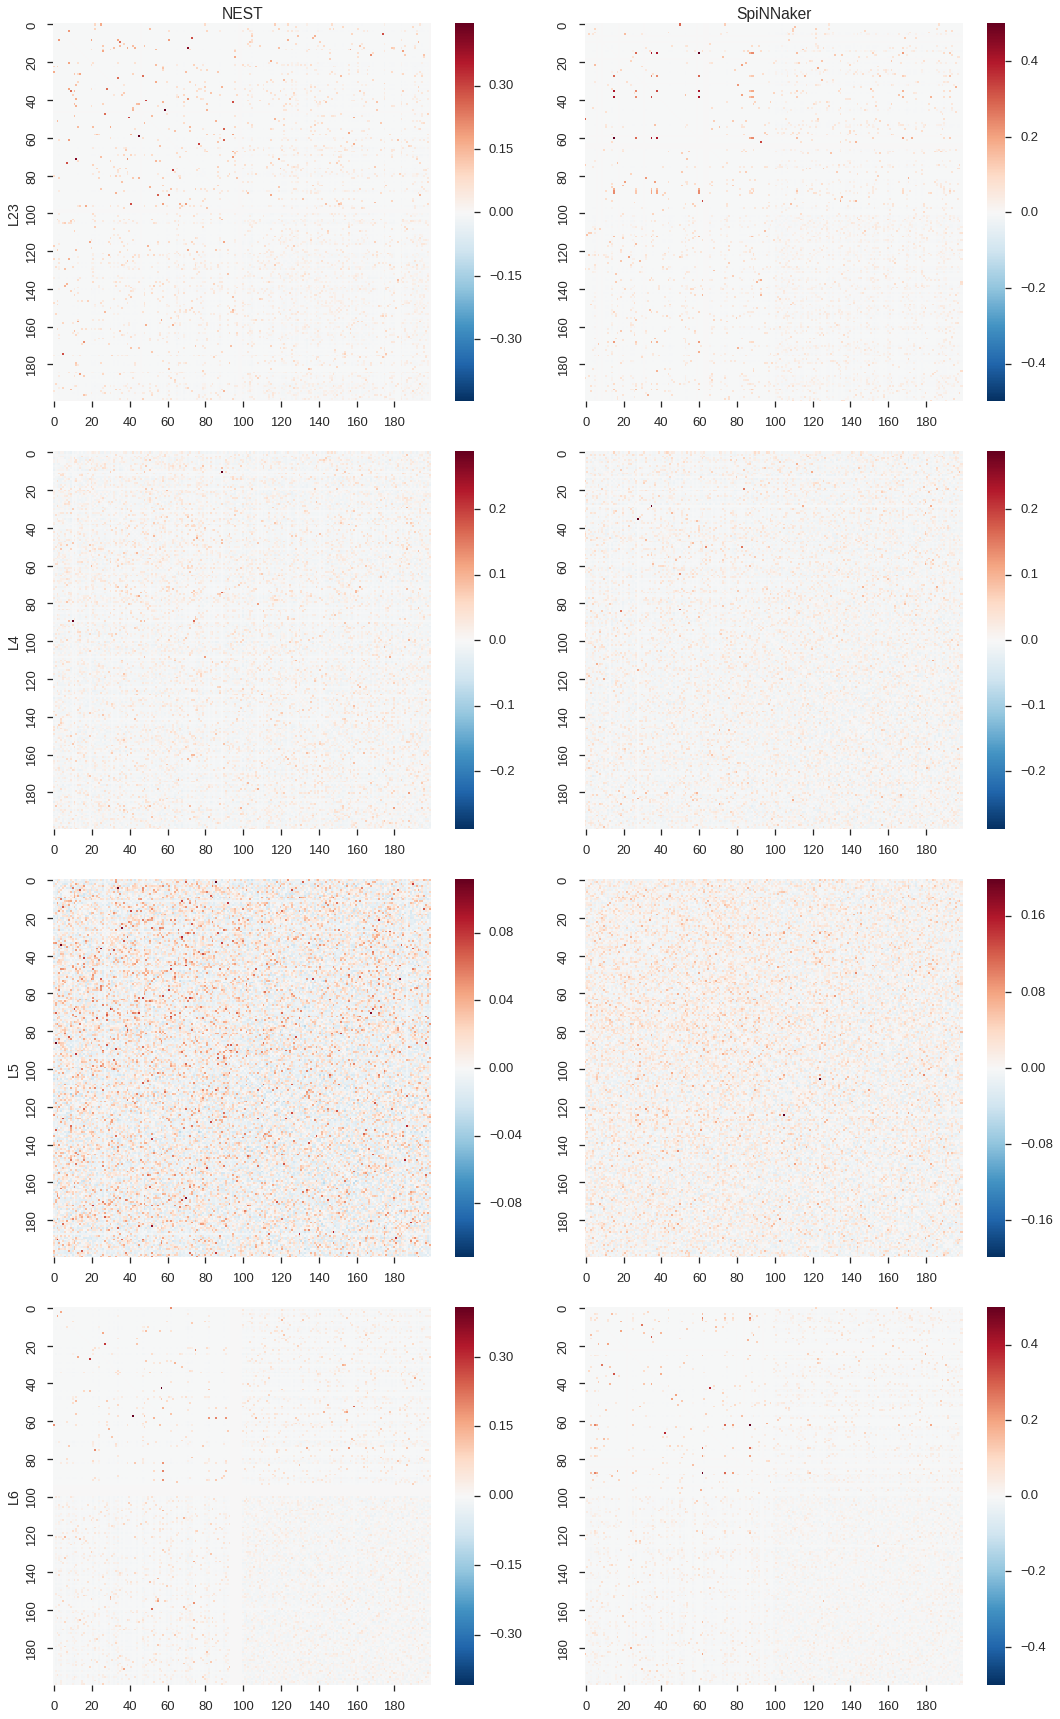

In [20]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,6*len(layer)))
fig.tight_layout()

corr_matrix_nest = [0]*len(layer)
corr_matrix_spinnaker = [0]*len(layer)

for layer_count, layer_name in enumerate(layer):
    corr_matrix_nest[layer_count] = matstat.corr_matrix(spiketrains_nest[layer_count][0][:] 
                                                        + spiketrains_nest[layer_count][1][:])
    corr_matrix_spinnaker[layer_count] = matstat.corr_matrix(spiketrains_spinnaker[layer_count][0][:] 
                                                             + spiketrains_spinnaker[layer_count][1][:])

    matstat.plot_matrix(corr_matrix_nest[layer_count], ax[layer_count][0], remove_autocorr=True)
    matstat.plot_matrix(corr_matrix_spinnaker[layer_count], ax[layer_count][1], remove_autocorr=True)
    
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])

ax[0][0].set_title('NEST')
ax[0][1].set_title('SpiNNaker');

#### Eigenvalue distribution

When the correlations between the spiketrains deviate from random the distribution of the eingenvalues of the correlation matrix changes. 
Especially when there is an assembly of correlated neurons an eigenvalue emerges which size tends towards the size of the assembly for higher correlations. Therefore an assembly can be described by its eigenvalue.

As description of the distribution of all eigenvalues one can look at their redundancy $R = \sqrt{\frac{\sum l_i^2 - N}{N(N-1)}}$ which is $0$ when the eigenvalues are evenly distributed and $1$ when all variance of the matrix is described by one eigenvalue.

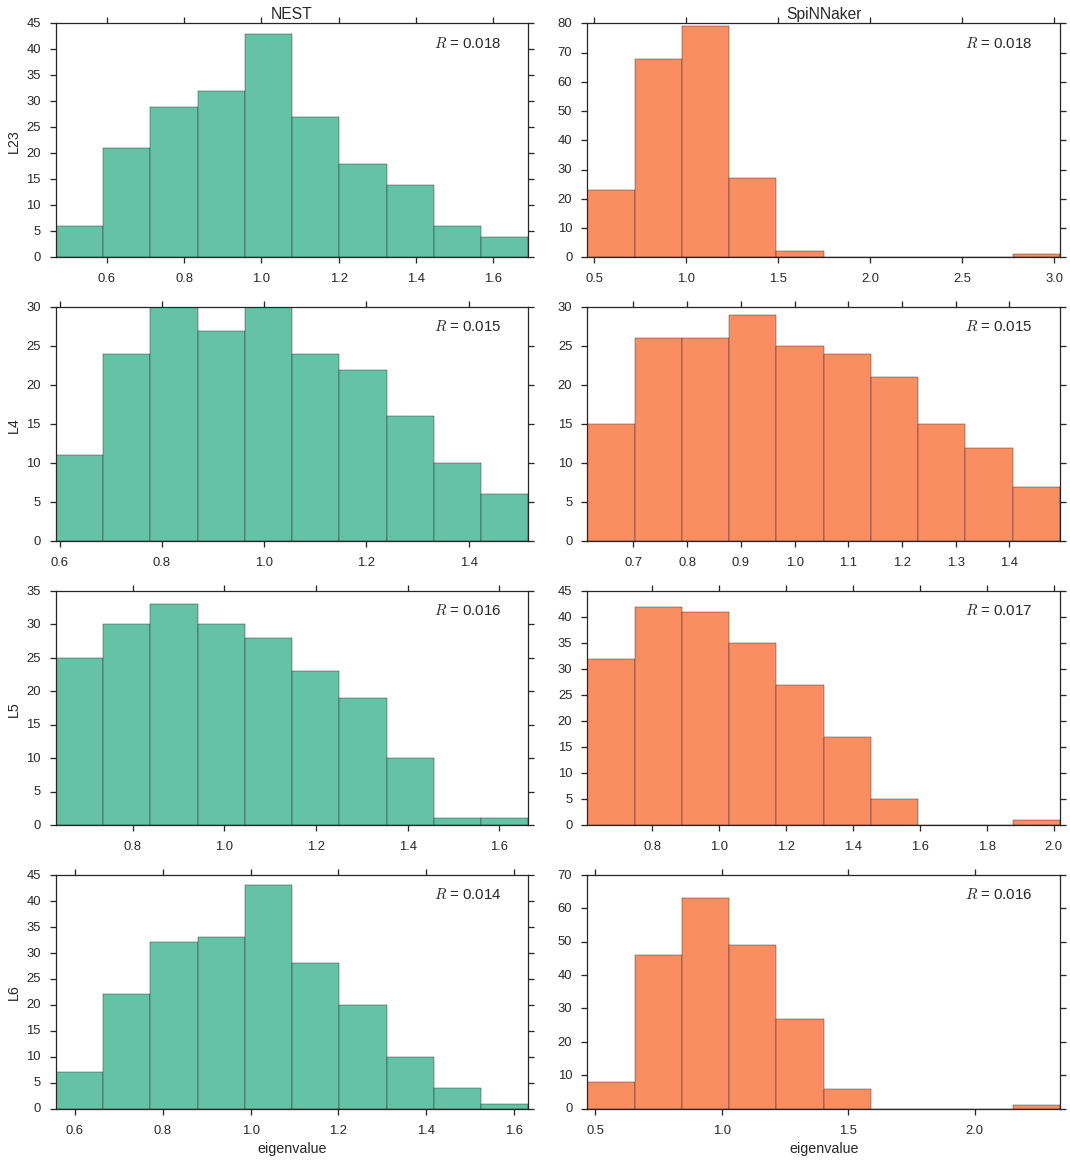

In [21]:
EWs_nest = [0]*len(layer)
EVs_nest = [0]*len(layer)
EWs_spinnaker = [0]*len(layer)
EVs_spinnaker = [0]*len(layer)

for layer_count, layer_name in enumerate(layer):
    EWs_nest[layer_count], EVs_nest[layer_count] = eigh(corr_matrix_nest[layer_count])
    EWs_spinnaker[layer_count], EVs_spinnaker[layer_count] = eigh(corr_matrix_spinnaker[layer_count])

fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    __ = matstat.eigenvalue_distribution(EWs_nest[layer_count], ax[layer_count][0],
                                         bins=10, color=sns.color_palette()[0], mute=True)
    ax[layer_count][0].text(.8, .9, r'$R$ = {:.3f}'.format(matstat.redundancy(EWs_nest[layer_count], mute=True)), 
                            fontsize=15, transform=ax[layer_count][0].transAxes)
    
    __ = matstat.eigenvalue_distribution(EWs_spinnaker[layer_count], ax[layer_count][1], 
                                         bins=10, color=sns.color_palette()[1], mute=True)
    ax[layer_count][1].text(.8, .9, r'$R$ = {:.3f}'.format(matstat.redundancy(EWs_spinnaker[layer_count], mute=True)), 
                            fontsize=15, transform=ax[layer_count][1].transAxes)
    
    ax[layer_count][0].set_xlabel('')
    ax[layer_count][1].set_xlabel('')
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])
    ax[layer_count][1].set_ylabel('')

ax[0][0].set_title('NEST')
ax[0][1].set_title('SpiNNaker')
ax[-1][0].set_xlabel('eigenvalue')
ax[-1][1].set_xlabel('eigenvalue');

#### Eigenvalue spectra

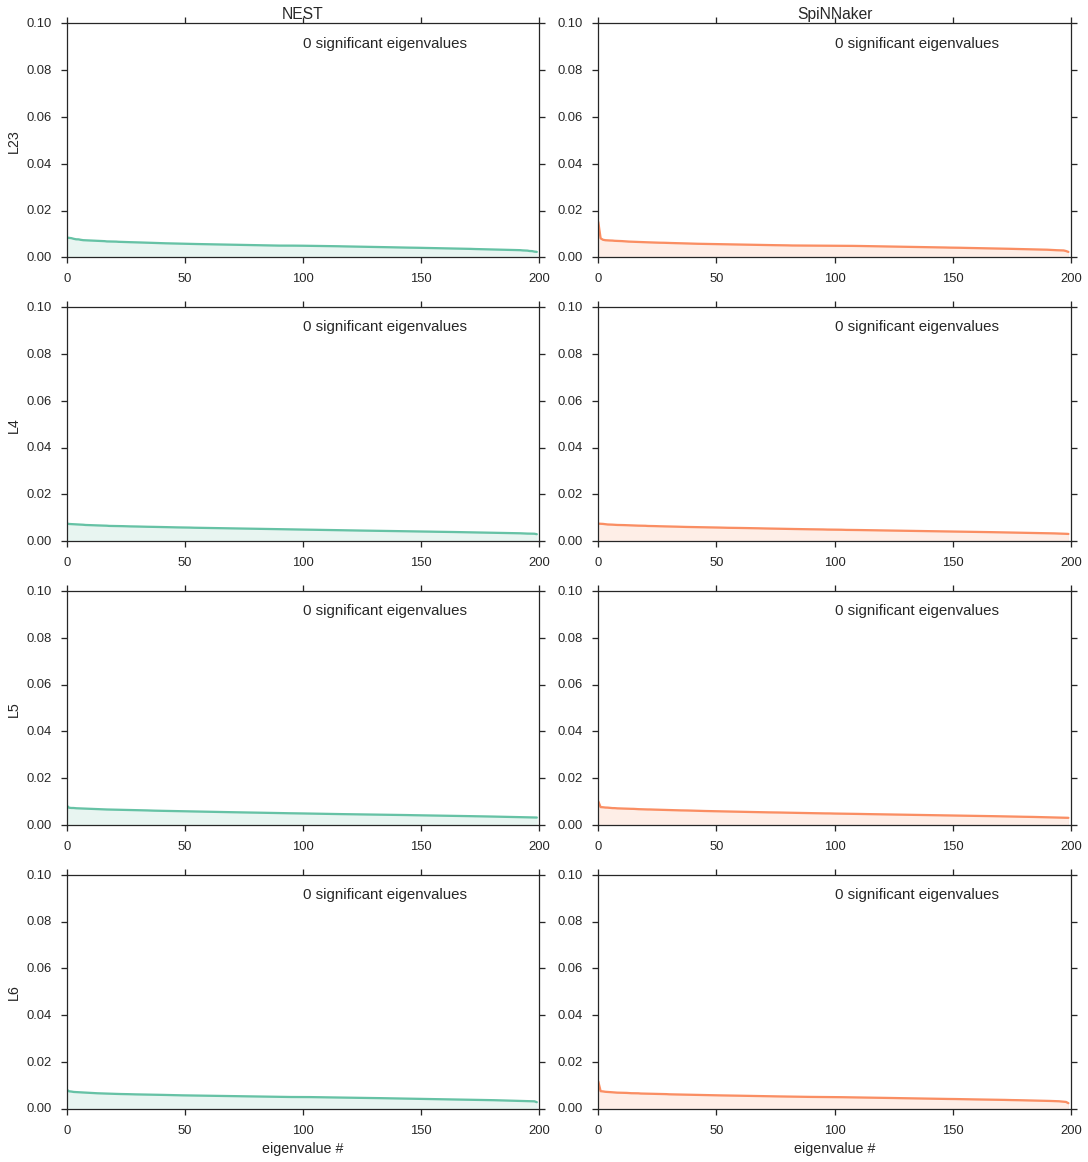

In [22]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,4*len(layer)))
fig.tight_layout()

sig_nbr_nest = [0]*len(layer)
sig_nbr_spinnaker = [0]*len(layer)

method = 'broken-stick' # 'SCREE', 'proportion', 'average-root'

for layer_count, layer_name in enumerate(layer):
    sig_nbr_nest[layer_count] = matstat.eigenvalue_spectra(EWs_nest[layer_count], method=method, 
                                                           ax=ax[layer_count][0], color=sns.color_palette()[0], 
                                                           mute=True)
    ax[layer_count][0].text(.5, .9, r'{} significant eigenvalue{}'\
                            .format(sig_nbr_nest[layer_count], 's' if sig_nbr_nest[layer_count]-1 else ''), 
                            fontsize=15, transform=ax[layer_count][0].transAxes)
    
    sig_nbr_spinnaker[layer_count] = matstat.eigenvalue_spectra(EWs_spinnaker[layer_count], method=method, 
                                                                ax=ax[layer_count][1], color=sns.color_palette()[1], 
                                                                mute=True)
    ax[layer_count][1].text(.5, .9, r'{} significant eigenvalue{}'\
                            .format(sig_nbr_spinnaker[layer_count], 's' if sig_nbr_nest[layer_count]-1 else ''), 
                            fontsize=15, transform=ax[layer_count][1].transAxes)
    
    ax[layer_count][0].set_xlabel('')
    ax[layer_count][1].set_xlabel('')
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])
    ax[layer_count][1].set_ylabel('')

ax[0][0].set_title('NEST')
ax[0][1].set_title('SpiNNaker')
ax[-1][0].set_xlabel('eigenvalue #')
ax[-1][1].set_xlabel('eigenvalue #');

#### Angles between eigenspaces

The angles between the principle components of two correlation matrices give a measure of how well the respective network exhibit the same highly correlated assemblies. But this angle can not be intuitively evalutated because distribution of random angels in N-dimensional space depends on the dimension and has therefore to be compared to the expectation value for random vectors.

When there are more than one assembly and thefore more than one significant eigenvector one can also compare them collectively by the angle between the eigenspaces they span.

In [23]:
for layer_count, layer_name in enumerate(layer): 
    print '\n\033[36mLayer: {}\033[0m'.format(layer_name.split('_')[1])
    sig_nbr = max(min(sig_nbr_nest[layer_count], sig_nbr_nest[layer_count]),1)
    _ = matstat.EV_angles(EVs_nest[layer_count][:, -sig_nbr:], EVs_spinnaker[layer_count][:, -sig_nbr:])


Layer: L23

Angles between the eigenvectors
	85.99°

Angle between eigenspaces
	85.99°

Layer: L4

Angles between the eigenvectors
	58.38°

Angle between eigenspaces
	58.38°

Layer: L5

Angles between the eigenvectors
	36.90°

Angle between eigenspaces
	36.90°

Layer: L6

Angles between the eigenvectors
	85.39°

Angle between eigenspaces
	85.39°


#### Detect Assemblies

First the number of potential assemblies is filtered by setting a limit (*EW_lim*) for the corresponding eigenvalue, since only eigenvalues which are significantly larger than their chance counterpart can be associated with assemblies.

In order to identify the neurons an eigenvector points to one has to estimate its size.
This can be done in three ways:

- Using the eigenvalue as a direct size estimate (is only appropriate for high correlation within assembly)
        -> detect_by='eigenvalue'
- By a threshold for the load of a neuron to the eigenvector (as example 2* 1/sqrt(N))
        -> detect_by= <float>
- By previous knowledge about the network
        -> detect_by= <int>

Once a collection of neurons is identified as an assembly, the previous estimation can be evaluated by the norm of the resulting part-eigenvector. A part-norm close to one indicates that there are probably no additional neurons of the assembly which were forgotten by the estimation.


In [24]:
argdict = {'detect_by':.2, 'EW_lim':1.5, 'sort':True, 'jupyter':True}
corr_order_nest = [0]*len(layer)
corr_order_spinnaker = [0]*len(layer)

for layer_count, layer_name in enumerate(layer):
    print "\n\033[32mLayer {}\033[0m\n".format(layer_name.split('_')[1])
    print "\033[36mNEST\033[0m\n"
    __, corr_order_nest[layer_count] = matstat.detect_assemblies(EVs_nest[layer_count], 
                                                                 EWs_nest[layer_count], 
                                                                 **argdict)

    print "\033[36mSpiNNaker\033[0m\n"
    __, corr_order_spinnaker[layer_count] = matstat.detect_assemblies(EVs_spinnaker[layer_count], 
                                                                      EWs_spinnaker[layer_count], 
                                                                      **argdict)


Layer L23

NEST

Assembly 1, eigenvalue 1.69, size 4
Neuron ID:	12	71	39	119		Norm
Portion:	0.58	0.53	0.35	0.31		0.92

Assembly 2, eigenvalue 1.67, size 5
Neuron ID:	95	41	58	67	70		Norm
Portion:	0.48	0.38	0.34	0.22	0.21		0.77

Assembly 3, eigenvalue 1.64, size 6
Neuron ID:	90	61	115	55	 8	194		Norm
Portion:	0.45	0.44	0.34	0.32	0.23	0.21		0.84

Assembly 4, eigenvalue 1.58, size 6
Neuron ID:	45	59	42	11	35	81		Norm
Portion:	0.48	0.36	0.33	0.26	0.24	0.21		0.80

Assembly 5, eigenvalue 1.54, size 6
Neuron ID:	54	13	96	72	30	21		Norm
Portion:	0.41	0.34	0.32	0.32	0.31	0.22		0.79

Assembly 6, eigenvalue 1.54, size 5
Neuron ID:	35	45	59	 9	11		Norm
Portion:	0.37	0.36	0.31	0.27	0.24		0.70

SpiNNaker

Assembly 1, eigenvalue 3.03, size 8
Neuron ID:	60	15	38	35	27	88	89	168		Norm
Portion:	0.43	0.42	0.37	0.37	0.29	0.25	0.24	0.21		0.94

Assembly 2, eigenvalue 1.63, size 6
Neuron ID:	93	62	135	143	140	14		Norm
Portion:	0.52	0.49	0.34	0.32	0.25	0.24		0.93

Assembly 3, eigenvalue 1.50, size 7
Neuron I


Layer L4

NEST

Assembly 1, eigenvalue 1.52, size 5
Neuron ID:	74	89	73	10	160		Norm
Portion:	0.38	0.35	0.25	0.23	0.22		0.66



SpiNNaker




Layer L5

NEST

Assembly 1, eigenvalue 1.66, size 1
Neuron ID:	64		Norm
Portion:	0.21		0.21



SpiNNaker

Assembly 1, eigenvalue 2.02, size 0
Neuron ID:		Norm
Portion:		0.00

Assembly 2, eigenvalue 1.52, size 1
Neuron ID:	35		Norm
Portion:	0.26		0.26

Assembly 3, eigenvalue 1.51, size 3
Neuron ID:	124	105	103		Norm
Portion:	0.38	0.32	0.24		0.55




Layer L6

NEST

Assembly 1, eigenvalue 1.63, size 6
Neuron ID:	58	86	91	53	82	173		Norm
Portion:	0.53	0.37	0.34	0.31	0.29	0.23		0.87



SpiNNaker

Assembly 1, eigenvalue 2.34, size 6
Neuron ID:	62	87	74	 5	78	 6		Norm
Portion:	0.50	0.48	0.35	0.31	0.25	0.22		0.90



#### Show Assemblies in Correlation Matrix

Based on the previously chosen parameters a set of potential assemblies consisting of certain neurons has been calculated. Sorting these by eigenvalues and the neurons by their respective load in the eigenvector, including also all non-significant eigenvalues results in an order for all neurons which when drawn in a heatmap as before facilitates the visual identification of correlated assemblies.

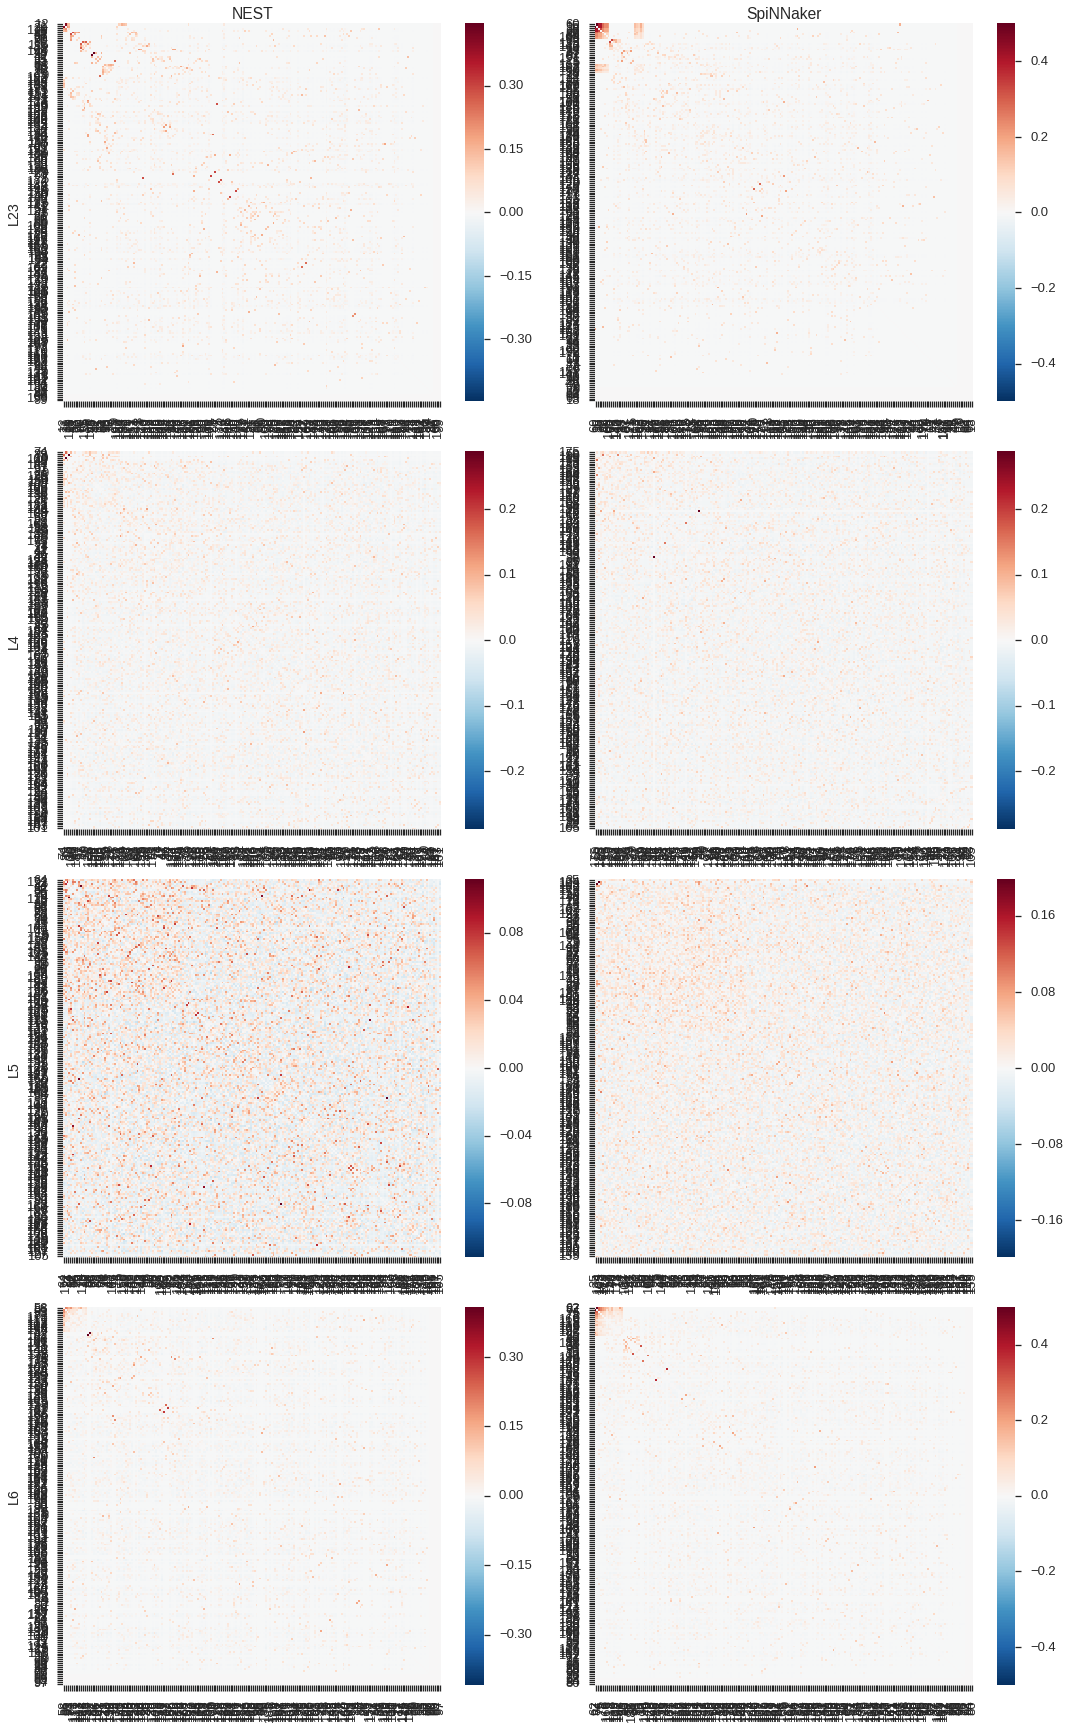

In [25]:
fig, ax = plt.subplots(nrows=len(layer), ncols=2, figsize=(15,6*len(layer)))
fig.tight_layout()

for layer_count, layer_name in enumerate(layer):
    ordered_matrix_nest = corr_matrix_nest[layer_count][corr_order_nest[layer_count], :] \
                                                       [:, corr_order_nest[layer_count]]
    ordered_matrix_spinnaker = corr_matrix_spinnaker[layer_count][corr_order_spinnaker[layer_count], :] \
                                                                 [:, corr_order_spinnaker[layer_count]]

    matstat.plot_matrix(ordered_matrix_nest, ax=ax[layer_count][0], 
                        labels=corr_order_nest[layer_count],remove_autocorr=True)
    matstat.plot_matrix(ordered_matrix_spinnaker, ax=ax[layer_count][1], 
                        labels=corr_order_spinnaker[layer_count], remove_autocorr=True)
    
    ax[layer_count][0].set_ylabel(layer_name.split('_')[1])
    
ax[0][0].set_title('NEST')
ax[0][1].set_title('SpiNNaker');